In [19]:
#Importing Packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Testing GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#Uploading CSV from Local Machine
from google.colab import files
uploaded = files.upload()

Saving HAM10000_metadata.csv to HAM10000_metadata.csv


In [87]:
classes = ["nv", "mel", "bkl", "bcc", "akiec", "vasc", "df"]

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [20]:
#Loading Metadata
import pandas as pd

df = pd.read_csv("HAM10000_metadata.csv")

df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


<Axes: >

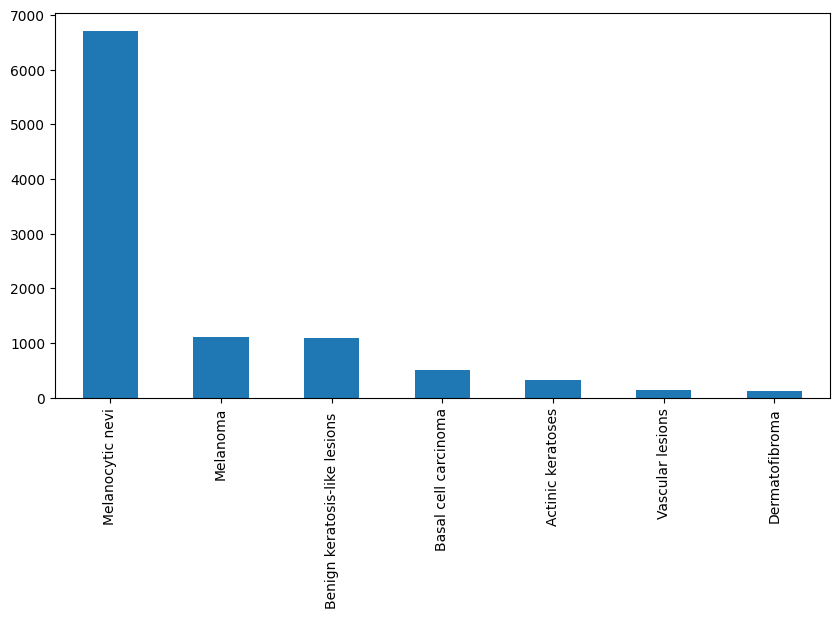

In [9]:
#Class Distribution
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: >

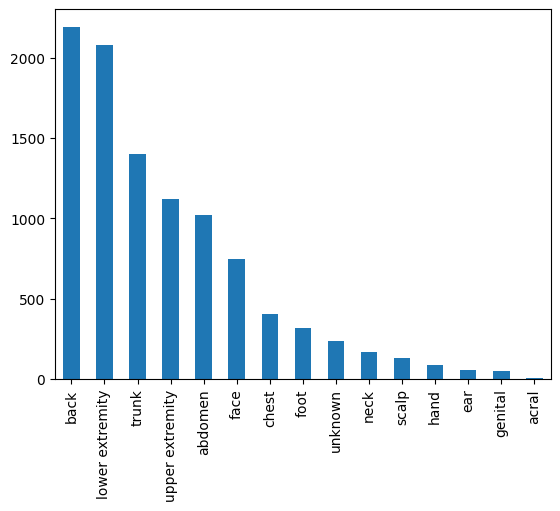

In [10]:
#Localization Distribution
df['localization'].value_counts().plot(kind='bar')

<Axes: >

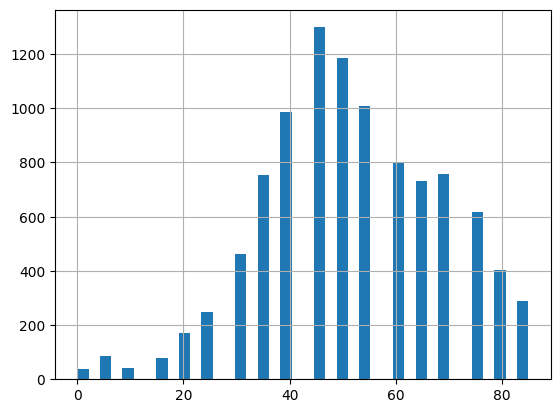

In [15]:
#Age Distribution
df['age'].hist(bins=40)

<Axes: >

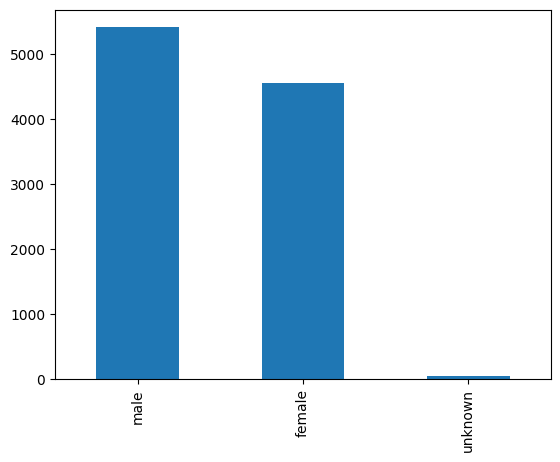

In [16]:
#Gender Distribution
df['sex'].value_counts().plot(kind='bar')

<Axes: xlabel='age', ylabel='cell_type_idx'>

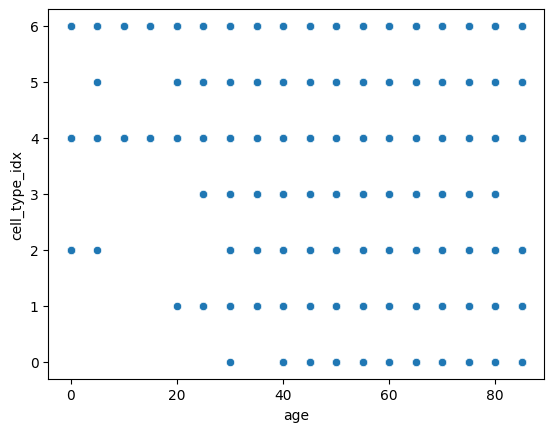

In [23]:
#Agewise Distribution of Skin Cancer Types
import seaborn as sns

sns.scatterplot(x='age', y='cell_type_idx', data=df)

In [18]:
#Loading Dataset
dataset = np.load(r"/content/drive/MyDrive/Skin Cancer Classification/dataset.npz")
x = dataset['x']
y = dataset['y']

print(x.shape)
print(y.shape)

(10015, 256, 256, 3)
(10015, 1)


In [24]:
#CNN Hyperparameters
nEpochs = 8
nBatch = 32
nFolds = 5

In [25]:
#Building CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, Flatten

model = Sequential([
      Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=x.shape[1:]),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.20),

      Conv2D(64, (3, 3), activation="relu", padding="same"),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.20),

      Conv2D(32, (3, 3), activation="relu", padding="same"),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.20),

      Conv2D(32, (3, 3), activation="relu", padding="same"),
      MaxPooling2D(pool_size=(2, 2)),
      Dropout(0.20),

      Flatten(),

      Dense(units=256, activation="relu"),
      Dense(units=7, activation="softmax")
  ])

In [15]:
#Fitting Data to Model
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import StratifiedKFold
import time

hists_CNN = {}
fold = 1

skf = StratifiedKFold(n_splits=nFolds, random_state=7, shuffle=True).split(x, y)
start = time.time()

for train, test in skf:
  model.compile(loss=SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy'])
  model.summary()

  model_name = f"/content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-{fold}.h5"
  hist = model.fit(x[train], y[train],
                   epochs=nEpochs,
                   validation_split=0.2,
                   batch_size=nBatch,
                   verbose=1)

  model.save(model_name)
  pred = model.predict(x[test]).ravel()
  hists_CNN[f"history-fold-{fold}"] = hist
  fold+=1

end=time.time()
print(f"Training Time: {end - start}seconds")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 64)       

In [36]:
#Evaluating Model Accuracy
from tensorflow.keras.models import load_model

accuracy, loss = [], []
for fold in range(1, 6):
  model_name = f"/content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-{fold}.h5"
  model = load_model(model_name)
  test_loss, test_accy = model.evaluate(x[test], y[test])

  accuracy.append(test_accy)
  loss.append(test_loss)

  print(f"Model Accuracy: {test_accy * 100}%")
  print(f"Model Loss: {test_loss}")

63/63 [==============================] - 2s 23ms/step - loss: 1.3615 - accuracy: 0.4938
Model Accuracy: 49.37593638896942%
Model Loss: 1.3614929914474487
63/63 [==============================] - 1s 21ms/step - loss: 1.2963 - accuracy: 0.7229
Model Accuracy: 72.29156494140625%
Model Loss: 1.296268343925476
63/63 [==============================] - 1s 20ms/step - loss: 1.9789 - accuracy: 0.8402
Model Accuracy: 84.02396440505981%
Model Loss: 1.9789234399795532
63/63 [==============================] - 1s 21ms/step - loss: 2.9721 - accuracy: 0.8562
Model Accuracy: 85.62156558036804%
Model Loss: 2.972053289413452
63/63 [==============================] - 2s 22ms/step - loss: 4.3240 - accuracy: 0.8083
Model Accuracy: 80.82875609397888%
Model Loss: 4.323993682861328


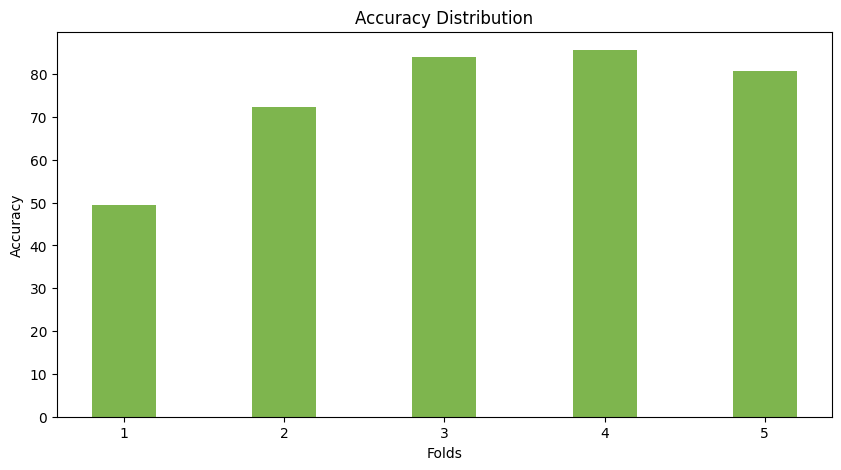

Max Accuracy: 85.62%


In [72]:
#Plotting Accuracy
fig = plt.figure(figsize = (10, 5))

plt.bar(list(range(1, 6)),
        [round(acc * 100, 2) for acc in accuracy],
        color ='#7eb54e',
        width = 0.4)

plt.xlabel("Folds")
plt.ylabel("Accuracy")
plt.title("Accuracy Distribution")
plt.show()

print(f"Max Accuracy: {round(max(accuracy) * 100, 2)}%")

In [75]:
#Loading Best Models
from tensorflow.keras.models import load_model
models = []

#Choosing Best Models
model_files = [
    r"/content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-3.h5",
    r"/content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-4.h5",
    r"/content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-5.h5",
]

for file in model_files:
  print(f"Loading {file}...")
  models.append(load_model(file, compile=True))

Loading /content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-3.h5...
Loading /content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-4.h5...
Loading /content/drive/MyDrive/Skin Cancer Classification/Models/model-kfold-epcohs-8-5.h5...


In [76]:
#Test Image Upload
uploadImg = files.upload()
filename = next(iter(uploadImg))

Saving ISIC_0034310.jpg to ISIC_0034310.jpg


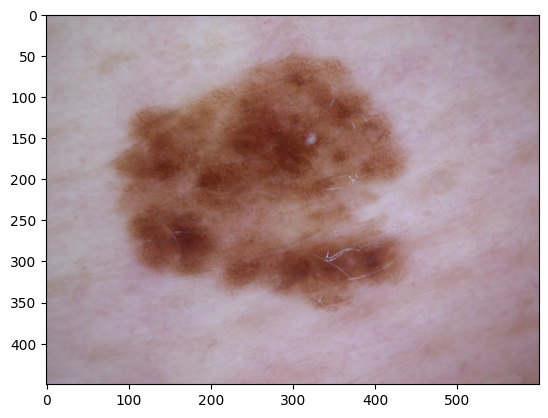

In [90]:
#Visualizing Image
import matplotlib.image as mpimg

img = mpimg.imread(filename)
imgplot = plt.imshow(img)
plt.show()

In [89]:
#Making Predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

x = np.zeros((1, 256, 256, 3), dtype=np.uint8)
img = load_img(filename, color_mode="rgb", target_size=(256, 256))
imgArr = img_to_array(img)

x[0] = imgArr
model_predictions = []
model_index = 1

for model in models:
  print(f"Predicting Model {model_index}..")

  model_predictions.append(model.predict(x))
  model_index+=1

predictions = np.mean(model_predictions, axis=0)
class_ = np.argmax(predictions)

print(class_)

#Resolving Class
type_ = classes[class_]
name = lesion_type_dict[type_]

print(f"\nClass Code: {class_}")
print(f"Class Type: {type_}")
print(f"Class Name: {name}")

Predicting Model 1..
1/1 [==============================] - 0s 89ms/step
Predicting Model 2..
1/1 [==============================] - 0s 20ms/step
Predicting Model 3..
1/1 [==============================] - 0s 21ms/step
0

Class Code: 0
Class Type: nv
Class Name: Melanocytic nevi
